In [1]:
import torch
import json
import numpy as np
import pandas as pd

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
# plt.style.use("research_note.mplstyle")

In [3]:
# custom libraries
import sys, os
sys.path.append(os.path.abspath('../'))
sys.path.append(os.path.abspath('../../spaths'))
print(f"{sys.executable = }")

from src.systems import rqp4_dat
from src import nets
import sf_nets.models as models
import sf_nets.datasets as datasets

sys.executable = '/Users/pzielinski/opt/anaconda3/envs/sf_nets/bin/python'


In [4]:
path = f'../models/rqp4/'
series_list = []
for file in os.listdir(path):
    filename = os.fsdecode(file)
    if filename.endswith(".pt"):
        train_data = torch.load(path + filename)
        par_dict = {
            key:val
            for key, val in train_data['params'].items()
            if key not in {'system', 'net_arch'}
        }
        par_dict['layers (i,l,[h])'] = train_data['params']['net_arch'].values()
        par_dict['best_valid_loss'] = train_data['history']['valid_losses'][train_data['state']['best_epoch']-1]
        series_list.append(par_dict)
models_df = pd.DataFrame(series_list)
models_df.set_index('model_id').sort_values(by='model_id')

,batch_size,max_epochs,burst_size,burst_dt,train_nsam,valid_nsam,learning_rate,"layers (i,l,[h])",best_valid_loss
model_id,,,,,,,,,
simple_1,16,150,10000,0.004,4000,1300,0.001,"(4, 1, [16])",0.805733
simple_2,16,150,10000,0.004,4000,1300,0.001,"(4, 1, [32])",0.763275
simple_3,16,150,10000,0.004,6000,2000,0.001,"(4, 1, [16])",0.824704
simple_4,16,300,10000,0.004,4000,1300,0.001,"(4, 1, [16, 16])",0.819068
simple_5,16,300,10000,0.004,4000,1300,0.001,"(4, 1, [32, 16])",0.442636
simple_6,16,300,10000,0.004,4000,1300,0.001,"(4, 1, [32, 32])",0.430068
simple_7,16,200,10000,0.004,4000,1300,0.001,"(4, 1, [8, 4])",0.871860


In [69]:
path = f'../results/models/rqp4/'
series_list = []
for file in os.listdir(path):
    filename = os.fsdecode(file)
    if filename.endswith(".pt"):
        train_data = torch.load(path + filename)
        par_dict = {
            key:val
            for key, val in train_data['config'].items()
            if key not in {'valid_split', 'loader', 'layers_to_prune'}
        }
#         par_dict['layers (i,l,[h])'] = train_data['state']['best_model_dict'].keys()
        par_dict['train_size'] = train_data['config']['loader']['train_size']
        par_dict['valid_size'] = train_data['config']['loader']['valid_size']
        par_dict['best_valid_loss'] = train_data['history']['valid_losses'][train_data['state']['best_epoch']-1]
        series_list.append(par_dict)
models_df = pd.DataFrame(series_list)
models_df.set_index('model_id').sort_values(by='model_id')

,max_epochs,batch_size,shuffle,burst_dt,burst_size,train_size,valid_size,best_valid_loss,target_sparsity
model_id,,,,,,,,,
pruned_0,30,16,True,0.004,10000,6238,2673,1.048699,0.8
pruned_1,200,16,True,0.004,10000,6238,2673,0.779951,0.7
simple_0,10,16,True,0.004,10000,6238,2673,1.099427,NaN
simple_7,200,16,True,0.004,10000,6238,2673,0.782885,NaN


## Plot loss for every epoch

In [57]:
model_id = 'pruned_1'

In [58]:
train_data = torch.load(f'../results/models/RQP4/{model_id}.pt')
config = json.load(open(f'../configs/RQP4/{model_id}.json'))
print(f'{train_data.keys() = }')

train_data.keys() = dict_keys(['config', 'history', 'state'])


In [59]:
train_losses = train_data['history']['train_losses']
valid_losses = train_data['history']['valid_losses']
epochs = range(1, train_data['config']['max_epochs']+1)
best_epoch = train_data['state']['best_epoch']

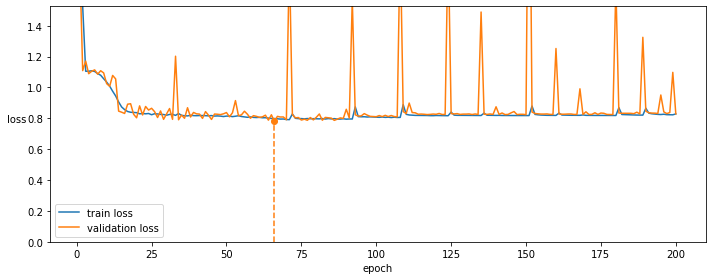

In [60]:
fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(epochs, train_losses, label="train loss")
loss_line, = ax.plot(epochs, valid_losses, label="validation loss")
ax.plot(best_epoch, valid_losses[best_epoch-1], 'o', color=loss_line.get_color())
plt.vlines(x=best_epoch, ymin=0, ymax=valid_losses[best_epoch-1], ls='--', color=loss_line.get_color())

ax.set_ylim([0.0, train_losses[1]])
ax.set_xlabel("epoch")
ax.set_ylabel("loss", rotation=0, labelpad=10)
ax.legend()

fig.tight_layout()
plt.show(fig)
plt.close(fig)

In [61]:
model = models.SimpleAutoencoder(**train_data['state']['args'])
mask_state_dict = dict(filter(lambda elem: elem[0].endswith('_mask'),
                                train_data['state']['best_model_dict'].items()))
orig_state_dict = dict(filter(lambda elem: elem[0].endswith('_orig'),
                                train_data['state']['best_model_dict'].items()))
rest = dict(filter(lambda elem: elem[0].endswith(('weight', 'bias')),
                                train_data['state']['best_model_dict'].items()))
state_dict = {
    key.replace('_orig',''): val_orig * val_mask
    for (key, val_orig), val_mask in zip(orig_state_dict.items(), mask_state_dict.values())
}
model.load_state_dict({**state_dict, **rest})

<All keys matched successfully>

In [62]:
model.eval()

SimpleAutoencoder(
  (encoder): Sequential(
    (enc_lay0): Linear(in_features=4, out_features=32, bias=True)
    (enc_act0): Sigmoid()
    (enc_lay1): Linear(in_features=32, out_features=16, bias=True)
    (enc_act1): Sigmoid()
    (enc_lay2): Linear(in_features=16, out_features=1, bias=False)
  )
  (decoder): Sequential(
    (dec_lay2): Linear(in_features=1, out_features=16, bias=False)
    (dec_act1): Sigmoid()
    (dec_lay1): Linear(in_features=16, out_features=32, bias=True)
    (dec_act0): Sigmoid()
    (dec_lay0): Linear(in_features=32, out_features=4, bias=True)
  )
)

In [64]:
train_dataset = datasets.RQP4("../data")
test_dataset = datasets.RQP4("../data", train=False)

In [65]:
#train_dataset = torch.utils.data.Subset(train_dataset, range(par_dict['train_size']))
# valid_dataset = torch.utils.data.Subset(train_dataset, range(train_data['params']['valid_nsam']))
train_test_ds = [train_dataset, test_dataset]

In [66]:
# train_coords = np.array([point.numpy() for point, _ in train_dataset]).T
# valid_coords = np.array([point.numpy() for point, _ in valid_dataset]).T
# slow_var, lat_var = np.array([(rqp4_dat['smap'](point), model(point)[1].item()) for point, covi in train_dataset]).T
# slow_var, lat_var = np.array([(rqp4_dat['smap'](point), model(point)[1].item()) for point, covi in valid_dataset]).T

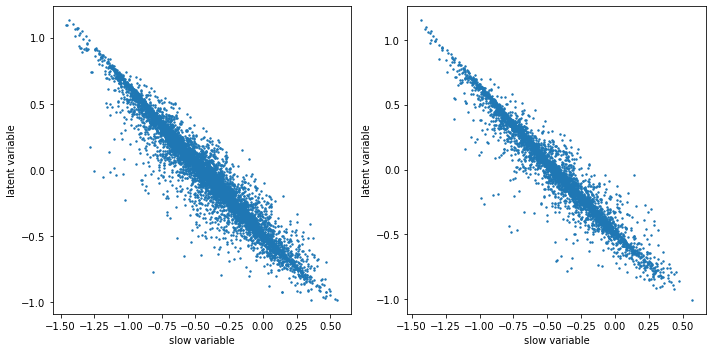

In [67]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))

for ax, ds in zip(axs, train_test_ds):
    slow_var, lat_var = np.array([(rqp4_dat['smap'](point), model(point)[1].item()) for point, covi in ds]).T
    ax.scatter(slow_var, lat_var, s=2)

    ax.set_ylabel('latent variable')
    ax.set_xlabel('slow variable')

fig.tight_layout()
plt.show()
plt.close(fig)

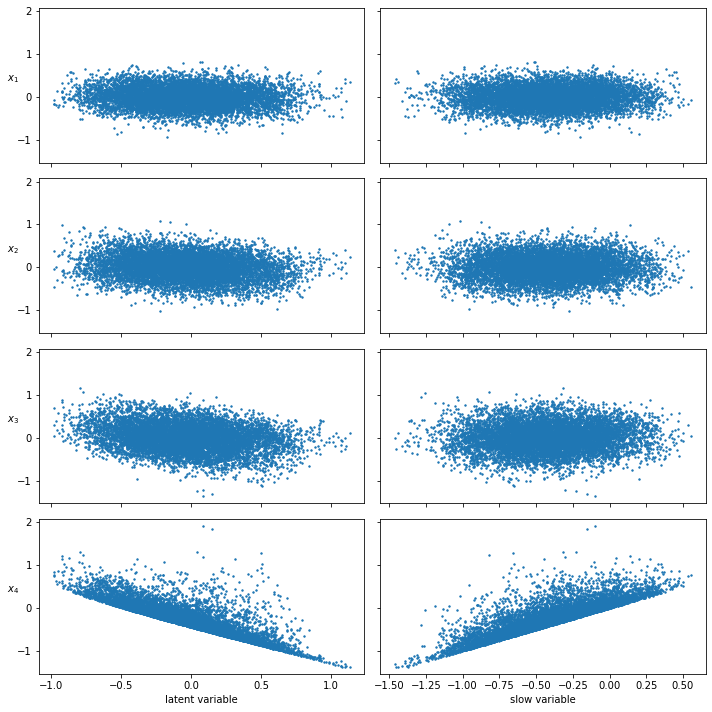

In [68]:
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(10,10), sharey=True, sharex='col')

coords = np.array([point.numpy() for point, _ in train_dataset]).T
slow_var, lat_var = np.array([(rqp4_dat['smap'](point), model(point)[1].item()) for point, covi in train_dataset]).T

for n, ax_row in enumerate(axs):
    ax_row[0].scatter(lat_var, coords[n], s=2)
    ax_row[1].scatter(slow_var, coords[n], s=2)
    ax_row[0].set_ylabel(f'$x_{n+1}$', rotation=0)

ax_row[0].set_xlabel('latent variable')
ax_row[1].set_xlabel('slow variable')

fig.tight_layout()
plt.show()
plt.close(fig)